 # Opis notatnika
 Analiza eksplotacyjna zbioru danych

In [1]:
import pandas as pd
import psycopg2
import matplotlib as plt
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

In [2]:
username = ''
password = ''

host = 'localhost'
database = 'airlines'
port = 5432

try:
    con = psycopg2.connect(user=username, password=password, host=host, database=database)
    cursor = con.cursor()
    print("Połączenie z bazą danych udane!")
except psycopg2.Error as e:
    print(f"Błąd połączenia: {e}")

Połączenie z bazą danych udane!


In [3]:
url = f"postgresql://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(url)

 Implementacja metody `read_sql_table`

In [4]:
def read_sql_table(table_name):
    df = pd.read_sql(table_name, con = engine)
    return df

In [5]:
flight_df = pd.read_csv(r'..\data\processed\flight_df_01.csv',sep=';', decimal='.' )

flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,1100-1199
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,1100-1199
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,5,4.0,0.0,10.0,0.0,3.0,2019,False,True,1100-1199
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,1100-1199
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,False,True,500-599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,3,NaN,NaN,NaN,NaN,NaN,2019,False,False,500-599
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,5,5.0,0.0,19.0,0.0,0.0,2019,True,False,1000-1099
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,False,False,500-599
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,5,0.0,0.0,66.0,0.0,0.0,2019,True,False,1000-1099


 # Wzbogacenie o `aircraft`
 Usunięcie z ramki kolumny `number_of_seats` oraz `id`. Na tej podstawie usuniecie duplikatów.  
 Następnie usunięcie duplikatów dla `tail_num` czyli sprawdzenie czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji.  

In [7]:
aircraft_df = read_sql_table('aircraft')

In [9]:
aircraft_df.drop(columns=['number_of_seats', 'id'], inplace=True)
aircraft_df.drop_duplicates(inplace=True)

In [11]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]

 ## Modyfikacja `aircraft_df`
 Dla powielonych `tail_num`, `manufacture_year` zostanie ustawiony jako najwyższy

In [13]:
duplicate_check = aircraft_df.groupby('tail_num')['manufacture_year'].nunique()

aircraft_df_duplicated = duplicate_check[duplicate_check > 1]

aircraft_df = aircraft_df.groupby('tail_num').agg({'manufacture_year': 'max'}).reset_index()

 ## Połączenie `aircraft_df` oraz `flight_df`
Usunięcie duplikatów, przedstawienie wyników w tabeli za pomocą wykresu punktowego.
Wyświetlenie na wykresie roczników samolotów, które wykonały łącznie więcej niż 10000 lotów.

In [15]:
tmp_flight_df = pd.merge(flight_df, aircraft_df, how='left', on='tail_num')

In [16]:
are_duplicates = tmp_flight_df.duplicated()

if are_duplicates.any():
    print("Występują duplikaty w ramce danych.")
else:
    print("Nie ma duplikatów w ramce danych.")

Nie ma duplikatów w ramce danych.


In [17]:
flight_df = tmp_flight_df

## Opóźnienia vs. rok produkcji samolotu cz. 1

In [18]:
delays_by_manufacture_year_df = flight_df.groupby('manufacture_year')['is_delayed'].mean()
delays_by_manufacture_year_df.head()

manufacture_year
1987.0    0.126411
1988.0    0.181388
1989.0    0.153846
1990.0    0.155453
1991.0    0.181795
Name: is_delayed, dtype: float64

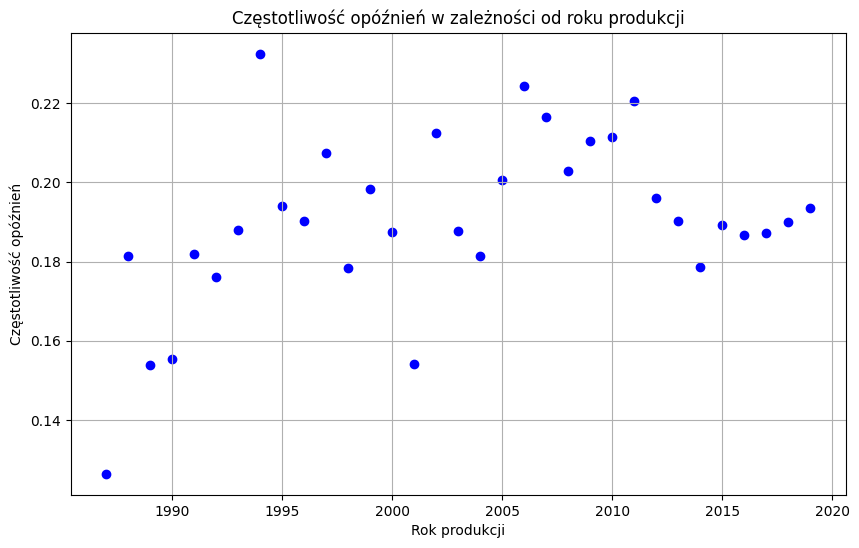

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(delays_by_manufacture_year_df.index, delays_by_manufacture_year_df.values, color='b', marker='o')

plt.xlabel('Rok produkcji')
plt.ylabel('Częstotliwość opóźnień')
plt.title('Częstotliwość opóźnień w zależności od roku produkcji')
plt.grid(True)

plt.show()

Modyfikacja wykresu tak, aby prezentował tylko te roczniki, które odbyły więcej niż 10000 lotów

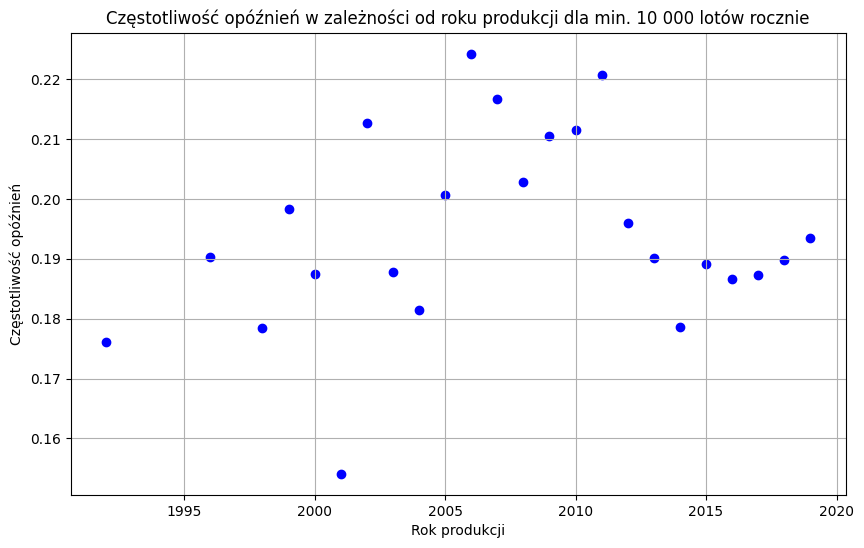

In [20]:
manufactury_counts = flight_df['manufacture_year'].value_counts()
filtered_records = flight_df[flight_df['manufacture_year'].isin(manufactury_counts[manufactury_counts > 10000].index)]

delays_by_manufacture_year_df2 = filtered_records.groupby('manufacture_year')['is_delayed'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(delays_by_manufacture_year_df2.index, delays_by_manufacture_year_df2.values, color='b', marker='o')

plt.xlabel('Rok produkcji')
plt.ylabel('Częstotliwość opóźnień')
plt.title('Częstotliwość opóźnień w zależności od roku produkcji dla min. 10 000 lotów rocznie')
plt.grid(True)

plt.show()

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Agregacja kolumny `manufacture_year` do kolumny `manufacture_year_agg` grupując dane co 3 lata
 Wyznaczenie top 5 roczników samolotu, które wykonały najwięcej lotów - do obliczeń wykorzystam `delays_by_manufacture_year_df`.

In [21]:
flight_df['manufacture_year_agg'] = (flight_df['manufacture_year'] // 3) * 3

In [22]:
flight_delays_by_manufacture_year_agg_df = flight_df.groupby('manufacture_year_agg')['is_delayed'].mean().reset_index()

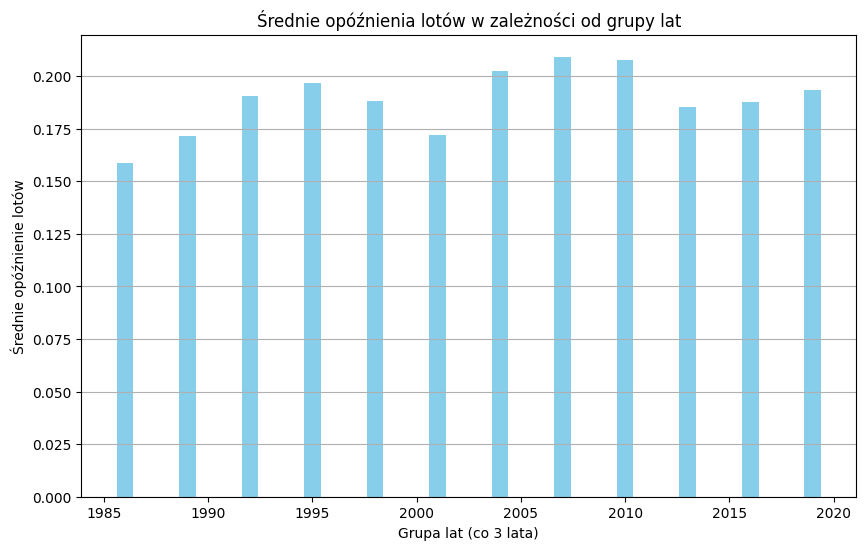

In [23]:
years = flight_delays_by_manufacture_year_agg_df['manufacture_year_agg']
delays = flight_delays_by_manufacture_year_agg_df['is_delayed']

plt.figure(figsize=(10, 6))
plt.bar(years, delays, color='skyblue')
plt.xlabel('Grupa lat (co 3 lata)')
plt.ylabel('Średnie opóźnienie lotów')
plt.title('Średnie opóźnienia lotów w zależności od grupy lat')
plt.grid(axis='y')

plt.show()

Wyznaczenie TOP 5 roczników produkcji - czyli sortując według liczby wykonanych lotów

In [24]:
sorted_delays_df = delays_by_manufacture_year_df.sort_values(ascending=False)

top_manufactured_df = sorted_delays_df.head(5)

top_manufactured_df

manufacture_year
1994.0    0.232518
2006.0    0.224261
2011.0    0.220629
2007.0    0.216644
2002.0    0.212610
Name: is_delayed, dtype: float64

 # Zapis ramki

In [25]:
flight_df.to_csv(
    r'..\data\processed\flight_df_02.csv',
    sep=';',
    decimal='.',
    index=False
)